# Imports & Definitions

The module `cairo` is used to generate the images for the animation.

The calculations will be done using 4-vectors, so the metric needed be defined as a `numpy.array`. The mostly minus convention will be used.

The function `lorentz_factor` takes in the relative velocity of a reference frame and returns the lorentz factor, i.e. $$ \gamma = \frac{1}{\sqrt{1-v^2}}$$

The function `lorentz_xform` takes in the relative velocity of a reference frame and returns the matrix for the associated lorentz trasform, i.e. satisfying
\begin{equation*}
    \begin{bmatrix}
        ct'\\
        x' \\
        y' \\
        z' \\
    \end{bmatrix} =
    \begin{bmatrix}
        \gamma & v\gamma & 0 & 0\\
        -v\gamma & \gamma & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
        ct\\
        x \\
        y \\
        z \\
    \end{bmatrix}
\end{equation*}

The function `get_speed`, $$ |\vec{v}| = \sqrt{ \frac{\vec{p}^2}{m^2 + \vec{p}^2} } $$

The IPython and io imports will be used to display an image generated with cairo in the notebook.

In [1]:
import cairo
import math
import numpy as np
import scipy.constants as consts

pi = math.pi

ceil = math.ceil

sqrt = math.sqrt
sin = math.sin
cos = math.cos
acos = math.acos
atan2 = math.atan2
exp = math.exp
log = math.log10

metric = np.diag([1, -1, -1, -1])

def lorentz_factor(rel_velocity):
    return 1/sqrt(1-rel_velocity**2)

def lorentz_xform(rel_velocity):
    gamma = lorentz_factor(rel_velocity)
    return np.array([
        [gamma, -rel_velocity*gamma, 0, 0],
        [-rel_velocity*gamma, gamma, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def get_momentum(four_momentum):
    return sqrt( four_momentum[1]**2 + four_momentum[2]**2 + four_momentum[3]**2 )

def get_speed(four_momentum):
    return sqrt( get_momentum(four_momentum)**2 / \
                ( four_momentum.T @ metric @ four_momentum + get_momentum(four_momentum)**2 ) )

def get_angle(four_momentum):
    return atan2( four_momentum[2], four_momentum[1] )
    

# this is to display cairo png in IPython
from IPython.display import Image, display, clear_output
from io import BytesIO

# Calculations

To begin, throughout this entire section of code, three primary reference frames will be given. The first frame of reference is one were the proton and electron can have an arbitrary energy and momentum relative to eachother. I will call this the collider frame. Next, the proton rest frame or the fixed target frame will be the frame in which (before the collision) the proton has no momentum. Finally, the center of mass frame is the frame in which the particles have equal momentum.

In the code, the different reference frames will be denoted by:
* Collider frame: `co_`
* Proton rest frame: `pr_`
* Center of mass frame `cm_`

First, the masses of the particles will be loaded using the module `scipy.constants`.

In [2]:
# Rest masses
proton_mass = consts.value('proton mass energy equivalent in MeV') * 1e-3 # GeV/c^2
electron_mass = consts.value('electron mass energy equivalent in MeV') * 1e-3 # GeV/c^2

The proton momentum and electron energy are given as 100 GeV/c and 11 GeV respectively. 
Using the mass-energy relationship, the proton energy and electron energy can be found using these equations:
\begin{align*} %Collider Equations.
E_p = \sqrt{m_p^2 + p_p^2}
\quad\text{&}\quad
p_e = \sqrt{E_e^2 - m_e^2}
\end{align*}
Then the four momenta for the proton and electron can be defined.
Additionally the total four momentum can be calculated, and the invariant will be calculated.

In [3]:
# Collider frame
co_proton_momentum = 100 # GeV/c
co_proton_energy = sqrt( proton_mass**2 + co_proton_momentum**2 )

co_electron_energy = 11 # GeV
co_electron_momentum = sqrt( co_electron_energy**2 - electron_mass**2 )

# define the four momentum
co_proton_4mom = np.array([ co_proton_energy, co_proton_momentum, 0, 0 ])
co_electron_4mom = np.array([ co_electron_energy, -co_electron_momentum, 0, 0 ])

The 4 momentum for the proton in the proton rest frame is $$ \tilde P_p = (m_p, 0, 0, 0) $$

while the proton's 4 momentum in the collider frame is known $$ P_p = (E_p, p_p, 0, 0) $$

Therefore the inverse lorentz transform from collider frame to proton rest frame is
$$
\begin{cases}
    E_p = \gamma ( m_p + v 0 ) \\
    p_p = \gamma ( v m_p + 0 )
\end{cases}
$$

Thus, by dividing these equations, a value for the relative velocity can be found $$ v = \frac{p_p}{E_p} = \frac{P_p^1}{P_p^0} $$

Following this, the lorentz transform will be applied to solve for the 4 momenta in the proton rest frame which are prefixed `pr_`.

In [4]:
# relative velocity from collider frame to proton rest frame
v_co_to_pr = co_proton_4mom[1]/co_proton_4mom[0]

# applying the lorentz transform
pr_proton_4mom = lorentz_xform(v_co_to_pr) @ co_proton_4mom
pr_electron_4mom = lorentz_xform(v_co_to_pr) @ co_electron_4mom

A very similar calculation to before will be done except it will use the total 4 momentum to go from the collider frame to the center of mass frame. The total 4 momentum was chosen because in the center of mass frame, the total momentum is 0.

$$ \dot P = \dot P_p + \dot P_e = (\dot E_p + \dot E_e, 0, 0, 0 ) $$

$$
\begin{cases}
    E_p + E_e = \gamma ( (\dot E_p + \dot E_e) - v 0 ) \\
    p_p + p_e = \gamma ( -v (\dot E_p + \dot E_e) + 0 )
\end{cases}
$$

$$ v = \frac{p_p + p_e}{E_p + E_e} = \frac{P_p^1+P_e^1}{P_p^0+P_e^0} $$

The found relative velocity will be used to solve for the 4 momenta in the center of mass frame which are prefixed `cm_`.

In [5]:
# relative velocity from collider frame to center of mass frame
v_co_to_cm = (co_proton_4mom[1]+co_electron_4mom[1])/(co_proton_4mom[0]+co_electron_4mom[0])

# applying the lorentz transform
cm_proton_4mom = lorentz_xform(v_co_to_cm) @ co_proton_4mom
cm_electron_4mom = lorentz_xform(v_co_to_cm) @ co_electron_4mom

Next, the angles will be calculated for after the collision. Because this is an elastic scattering, the momentum before the collision is exactly equal to the momentum after. Therefore, in the center of mass frame, this would simply be a rotation of the momenta. All of the four momenta after the collision will be appropriately named with the suffix `_after`.

To calculate the angle, more parameters will need to be specified, the square momentum transfer and a dimensionaless quantity which characterizes the deep inelastic scattering. Here, we will use the convention of naming the momentum transfer $Q^2 = -(P_e - P_{e,\text{after}})^2$ The second paramter is the dimensionless quantity $x_B$ which can be related to $Q^2$ by $$ x_b = \frac{Q^2}{2m\omega} $$ Here, $\omega$ is the difference of the electrons energy in the proton rest frame.

To solve for the angle, the square momentum transfer will be used $-Q^2 = (P_e - P_{e,\text{after}})^2$, and after expanding out in the proton rest frame and approximating using $m_e = 0$, it is found that $$ -Q^2 = P_e^2 -2 P_e \cdot P_{e,\text{after}} + P_{e,\text{after}}^2 = -2 E_e E_{e,\text{after}} (1+\cos \theta ) $$

Because $E_{e,\text{after}}$ can be gathered from $\omega$, the angle of the electron in the proton rest frame must be generated from $$ \cos \theta = \frac{Q^2}{2 E_e E_{e,\text{after}}} -1 $$

Finally, find the proton mess using conservation, i.e. $$ k + P = k' + P' $$

In [6]:
Q2 = 1 # GeV
xB = 0.1 # dim'less

pr_electron_energy_after = pr_electron_4mom[0] - Q2/2/proton_mass/xB

pr_electron_angle_after = acos( -1 + Q2/(2*pr_electron_4mom[0]*pr_electron_energy_after) )

# using the approximation of electron momentum = energy
pr_electron_4mom_after = np.array([pr_electron_energy_after,
                                   pr_electron_energy_after*cos(pr_electron_angle_after),
                                   pr_electron_energy_after*sin(pr_electron_angle_after),
                                   0])

# conservation of momentum says before = after
pr_proton_4mom_after = pr_proton_4mom + pr_electron_4mom - pr_electron_4mom_after

Now that the center of mass frame has its four momentum calculated for after the collision, a simple Lorentz transform will be used to calculate the four momentum in the different frames

In [7]:
# now the other frames can be calculated after the collision
co_proton_4mom_after = lorentz_xform(-v_co_to_pr) @ pr_proton_4mom_after
co_electron_4mom_after = lorentz_xform(-v_co_to_pr) @ pr_electron_4mom_after

cm_proton_4mom_after = lorentz_xform(v_co_to_cm) @ co_proton_4mom_after
cm_electron_4mom_after = lorentz_xform(v_co_to_cm) @ co_electron_4mom_after

In [8]:
# now to extract the useful values

# collider
# proton
co_proton_momentum = get_momentum(co_proton_4mom)
co_proton_speed = get_speed(co_proton_4mom)
co_proton_angle = get_angle(co_proton_4mom)

co_proton_momentum_after = get_momentum(co_proton_4mom_after)
co_proton_speed_after = get_speed(co_proton_4mom_after)
co_proton_angle_after = get_angle(co_proton_4mom_after)

# electron
co_electron_momentum = get_momentum(co_electron_4mom)
co_electron_speed = get_speed(co_electron_4mom)
co_electron_angle = get_angle(co_electron_4mom)

co_electron_momentum_after = get_momentum(co_electron_4mom_after)
co_electron_speed_after = get_speed(co_electron_4mom_after)
co_electron_angle_after = get_angle(co_electron_4mom_after)

# center of mass
# proton
cm_proton_momentum = get_momentum(cm_proton_4mom)
cm_proton_speed = get_speed(cm_proton_4mom)
cm_proton_angle = get_angle(cm_proton_4mom)

cm_proton_momentum_after = get_momentum(cm_proton_4mom_after)
cm_proton_speed_after = get_speed(cm_proton_4mom_after)
cm_proton_angle_after = get_angle(cm_proton_4mom_after)

# electron
cm_electron_momentum = get_momentum(cm_electron_4mom)
cm_electron_speed = get_speed(cm_electron_4mom)
cm_electron_angle = get_angle(cm_electron_4mom)

cm_electron_momentum_after = get_momentum(cm_electron_4mom_after)
cm_electron_speed_after = get_speed(cm_electron_4mom_after)
cm_electron_angle_after = get_angle(cm_electron_4mom_after)

# proton rest
# proton
pr_proton_momentum = get_momentum(pr_proton_4mom)
pr_proton_speed = get_speed(pr_proton_4mom)
pr_proton_angle = get_angle(pr_proton_4mom)

pr_proton_momentum_after = get_momentum(pr_proton_4mom_after)
pr_proton_speed_after = get_speed(pr_proton_4mom_after)
pr_proton_angle_after = get_angle(pr_proton_4mom_after)

# electron
pr_electron_momentum = get_momentum(pr_electron_4mom)
pr_electron_speed = get_speed(pr_electron_4mom)
pr_electron_angle = get_angle(pr_electron_4mom)

pr_electron_momentum_after = get_momentum(pr_electron_4mom_after)
pr_electron_speed_after = get_speed(pr_electron_4mom_after)
pr_electron_angle_after = get_angle(pr_electron_4mom_after)

# Animation

In [9]:
# these are some constants for the animation
# such as the colors
w, h = 500, 500

red = (255/255, 64/255, 64/255, 1)
blue = (64/255, 217/255, 255/255, 1)

purple = (178/255, 64/255, 255/255, 1)
green = (137/255, 255/255, 64/255, 1)

almost_black = (25/255, 25/255, 25/255, 1)

unit_circle_radius = 0.5-0.01/2

These functions are used for drawing.

In [10]:
def draw_arrow(ctx, length_of_arrow, x = 0, y = 0, angle = 0):
    
    ctx.save()
    ctx.translate(x, y)
    ctx.rotate(angle)
    
    
    length_of_arrow_head = ctx.get_line_width()*3.42709
    
    if abs(length_of_arrow) < length_of_arrow_head:
        length_of_arrow = (length_of_arrow)/abs(length_of_arrow)*length_of_arrow_head
    
    ctx.move_to(0, 0)
    ctx.rel_line_to(length_of_arrow-length_of_arrow_head, 0)
    ctx.stroke()

    r = sqrt(2)*sqrt(1-cos(3*pi/4)) # this is the length of the chord of 3pi/4

    ctx.move_to(0, 0)
    ctx.rel_move_to(length_of_arrow-length_of_arrow_head, 0)
    ctx.rel_line_to(length_of_arrow_head*cos(3*pi/4), length_of_arrow_head*sin(3*pi/4))
    ctx.rel_line_to(r*length_of_arrow_head*cos(-pi/8), r*length_of_arrow_head*sin(-pi/8))
    ctx.rel_line_to(r*length_of_arrow_head*cos(-7*pi/8), r*length_of_arrow_head*sin(-7*pi/8))
    ctx.close_path()
    ctx.fill()
    
    ctx.restore()

def draw_circle_with_notches(ctx, radius = 1, major_notches = 16, minor_notches = 4):
    # Circle with notches
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, radius, 0, 2*pi)
    ctx.stroke()

    for minute in range( int(major_notches) ):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range( int(minor_notches) ):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)

## Testing

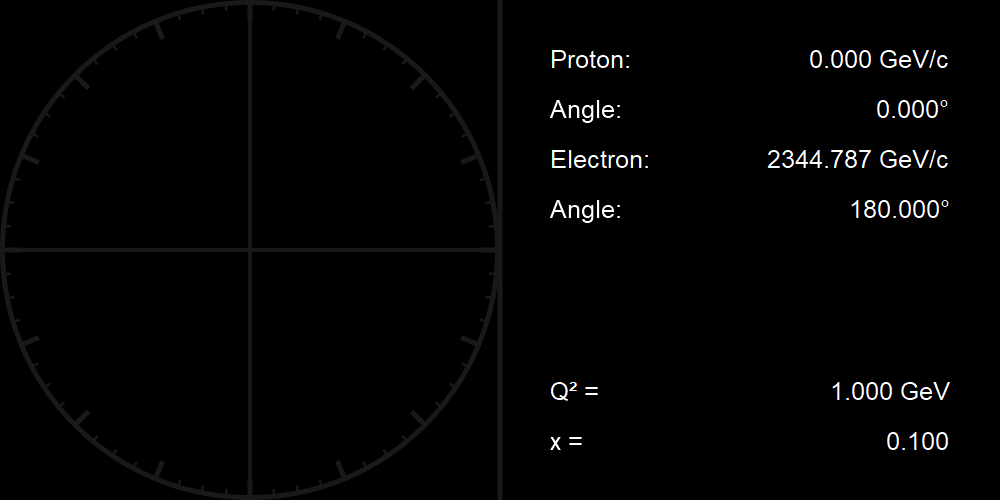

In [11]:
# initialize surface
surface = cairo.ImageSurface(cairo.Format.ARGB32, int(w*2), int(h*1) )
ctx = cairo.Context(surface)

ctx.scale(w, h)

# Text background
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(1, 0, 1, 1)
ctx.fill()

# Write text
ctx.set_font_size(0.05)
ctx.set_source_rgba(1, 1, 1, 1)
ctx.move_to(1.1, 0)
th = ctx.text_extents(f'Proton:').height
ctx.move_to(1.1, 0.1+th)
ctx.show_text(f'Proton:')
ctx.move_to(1.9-ctx.text_extents(f'{pr_proton_momentum:.3f} GeV/c').width, 0.1+th)
ctx.show_text(f'{pr_proton_momentum:.3f} GeV/c')
ctx.move_to(1.1, 0.1*2+th)
ctx.show_text(f'Angle:')
ctx.move_to(1.9-ctx.text_extents(f'{math.degrees(pr_proton_angle):.3f}°').width, 0.1*2+th)
ctx.show_text(f'{math.degrees(pr_proton_angle):.3f}°')
ctx.move_to(1.1, 0.1*3+th)
ctx.show_text(f'Electron:')
ctx.move_to(1.9-ctx.text_extents(f'{pr_electron_momentum:.3f} GeV/c').width, 0.1*3+th)
ctx.show_text(f'{pr_electron_momentum:.3f} GeV/c')
ctx.move_to(1.1, 0.1*4+th)
ctx.show_text(f'Angle:')
ctx.move_to(1.9-ctx.text_extents(f'{math.degrees(pr_electron_angle):.3f}°').width, 0.1*4+th)
ctx.show_text(f'{math.degrees(pr_electron_angle):.3f}°')

ctx.move_to(1.1, 0.1*8)
ctx.show_text(f'Q² =')
ctx.move_to(1.9-ctx.text_extents(f'{Q2:.3f} GeV').width, 0.1*8)
ctx.show_text(f'{Q2:.3f} GeV')
ctx.move_to(1.1, 0.1*9)
ctx.show_text(f'x =')
ctx.move_to(1.9-ctx.text_extents(f'{xB:.3f}').width, 0.1*9)
ctx.show_text(f'{xB:.3f}')

# Animation background 
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 0, 1, 1)
ctx.fill()

ctx.translate(0.5, 0.5) # move the origin to the center of the collision

# Axes
ctx.set_source_rgba(*almost_black)
ctx.set_line_width(0.0075)

ctx.move_to(-0.5, 0)
ctx.line_to(0.5, 0)
ctx.stroke()

ctx.move_to(0, -0.5)
ctx.line_to(0, 0.5)
ctx.stroke()

# Cricle with notches
ctx.set_source_rgba(*almost_black)
draw_circle_with_notches(ctx, unit_circle_radius, 16, 4)


# Separator
ctx.move_to(0.5, -0.5)
ctx.line_to(0.5, 0.5)
ctx.stroke()

# save as .png
# surface.write_to_png(f'Q2-1GeV_xB-0.5.png')

# display in notebook
with BytesIO() as fileobj:
    surface.write_to_png(fileobj)
    display(Image(fileobj.getvalue(), width=w*1.75))

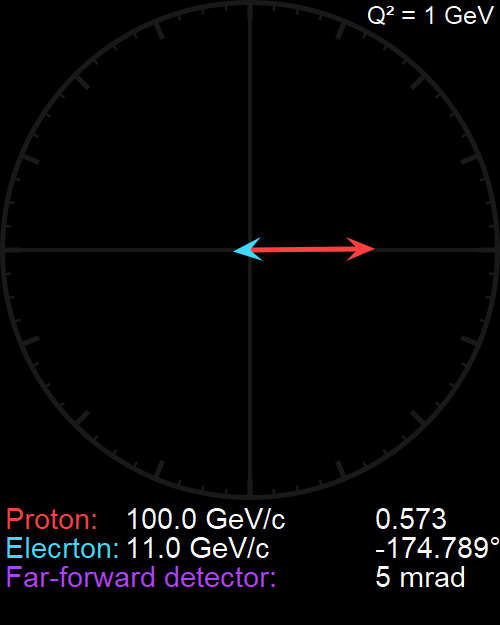

In [12]:
# initialize surface
surface = cairo.ImageSurface(cairo.Format.ARGB32, w, int(h*1.25) )
ctx = cairo.Context(surface)

ctx.scale(w, h)

# Background 
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 0, 1, 1)
ctx.fill()

ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()

# text
ctx.save()
ctx.translate(0, 1)

left_margin = 0.01
right_margin = 1-left_margin
tab1 = 0.25
tab2 = 0.75

font_size = 0.25/4.3
ctx.set_font_size(font_size)

# proton text
ctx.set_source_rgba(*red)
ctx.move_to(left_margin, font_size)
ctx.show_text(f'Proton: ')
ctx.stroke()

ctx.set_source_rgba(1, 1, 1, 1)
ctx.move_to(tab1, font_size)
ctx.show_text(f'{co_proton_momentum_after:.1f} GeV/c')
ctx.move_to(tab2, font_size)
ctx.show_text(f'{-math.degrees(co_proton_angle_after):.3f}')
ctx.stroke()

# electron text
ctx.set_source_rgba(*blue)
ctx.move_to(left_margin, font_size*2)
ctx.show_text(f'Elecrton: ')
ctx.stroke()

ctx.set_source_rgba(1, 1, 1, 1)
ctx.move_to(tab1, font_size*2)
ctx.show_text(f'{co_electron_momentum_after:.1f} GeV/c')
ctx.move_to(tab2, font_size*2)
ctx.show_text(f'{-math.degrees(co_electron_angle_after):.3f}°')
ctx.stroke()

# far forward text
ctx.set_source_rgba(*purple)
ctx.move_to(left_margin, font_size*3)
ctx.show_text(f'Far-forward detector:')
ctx.stroke()

ctx.set_source_rgba(1, 1, 1, 1)
ctx.move_to(tab2, font_size*3)
ctx.show_text(f'5 mrad')
ctx.stroke()

ctx.restore()

ctx.translate(0.5, 0.5)

# Axes
ctx.set_source_rgba(*almost_black)
ctx.set_line_width(0.0075)

ctx.move_to(-0.5, 0)
ctx.line_to(0.5, 0)
ctx.stroke()

ctx.move_to(0, -0.5)
ctx.line_to(0, 0.5)
ctx.stroke()

# Unit circle with notches
ctx.set_source_rgba(*almost_black)
ctx.set_line_width(0.01)

ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
ctx.stroke()

for minute in range(16):
    ctx.move_to(unit_circle_radius, 0)
    ctx.line_to(unit_circle_radius*12/13, 0)
    ctx.stroke()

    for second in range(4):
        ctx.set_line_width(0.005)
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*0.97, 0)
        ctx.rotate(2*pi/16/4)
        ctx.stroke()
        ctx.set_line_width(0.01)

# more text!
ctx.set_font_size(0.05)
ctx.set_source_rgba(1, 1, 1, 1)
(tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
ctx.show_text(f'Q² = {Q2:.0f} GeV')
ctx.stroke()
        
# animation
t1 = 0.5/co_proton_speed
t2 = 0.5/cos(co_proton_angle_after)/co_proton_speed_after

# t = 0.5/co_proton_speed*0
t = 0.5/cos(co_proton_angle_after)/co_proton_speed_after*0

# Draw the proton vector
ctx.save()
# ctx.rotate( co_proton_angle )
ctx.rotate( co_proton_angle_after )
ctx.set_source_rgba(*red)
ctx.set_line_width(0.01)
# draw_arrow(ctx, 0.25, t*co_proton_speed -0.75, 0, 0)
draw_arrow(ctx, 0.25, t*co_proton_speed_after, 0, 0)
ctx.stroke()
# ctx.arc(0, 0, 0.02, 0, 2*pi)
# ctx.fill()
ctx.restore()

# Draw the electron vector
ctx.save()
# ctx.rotate( co_electron_angle )
ctx.rotate( co_electron_angle_after )
ctx.set_source_rgba(*blue)
ctx.set_line_width(0.01)
ah = ctx.get_line_width()*3.42709
# draw_arrow(ctx, 0.25*co_electron_momentum/co_proton_momentum, t*co_electron_speed-0.5-ah, 0, 0)
draw_arrow(ctx, 0.25*co_electron_momentum_after/co_proton_momentum_after, t*co_electron_speed_after, 0, 0)
ctx.stroke()
ctx.restore()

# # draw detector
# ctx.save()
# ctx.rotate( co_proton_angle_after )
# ctx.set_source_rgba(*purple)
# ctx.rotate(2.5/1000)
# ctx.arc(0, 0, unit_circle_radius, -5/1000, 0)
# ctx.line_to(unit_circle_radius*12/13, 0)
# ctx.scale(1, -1)
# ctx.arc(0, 0, unit_circle_radius*12/13, 0, 5/1000)
# ctx.fill()
# ctx.restore()

# save as .png
# surface.write_to_png(f'frames/test.png')

# display in notebook
with BytesIO() as fileobj:
    surface.write_to_png(fileobj)
    display(Image(fileobj.getvalue(), width=w))

## Center of Mass Frame

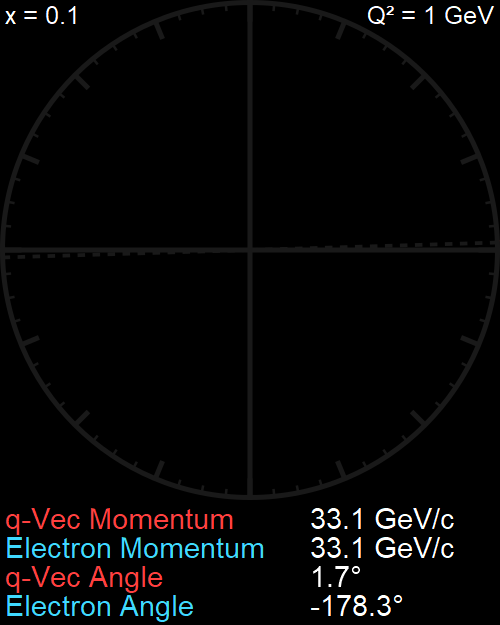

In [19]:
# initialize surface
surface = cairo.ImageSurface(cairo.Format.ARGB32, w, int(h*1.25))
ctx = cairo.Context(surface)

ctx.scale(w, h)

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'Proton Momentum', f'{cm_proton_momentum:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{cm_electron_momentum:.1f} GeV/c'],
         [red, 'Proton Angle', f'{math.degrees(cm_proton_angle):.1f}°'],
         [blue, 'Electron Angle', f'{math.degrees(cm_electron_angle):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

# these are the different times for the two animations
t1 = abs( 0.5/cm_proton_speed )
t2 = abs( 0.5/cos(cm_proton_angle_after)/cm_proton_speed_after )
T = t1 + t2

ctx.save()
ctx.translate(0.5, 0.5)

for frame, t in enumerate( np.linspace(0, t1, ceil(5*60*t1/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)

    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')
            
    # animation

    # Draw the proton vector
    ctx.save()
    ctx.rotate( cm_proton_angle )
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*cm_proton_speed -0.75, 0, 0)
    ctx.stroke()
    # ctx.arc(0, 0, 0.02, 0, 2*pi)
    # ctx.fill()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( cm_electron_angle )
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*cm_electron_speed-0.75, 0, 0)
    ctx.stroke()
    ctx.restore()

    # save as .png
    surface.write_to_png(f'center_of_mass/{frame:03d}.png')

ctx.restore()

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'q-Vec Momentum', f'{cm_proton_momentum_after:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{cm_electron_momentum_after:.1f} GeV/c'],
         [red, 'q-Vec Angle', f'{-math.degrees(cm_proton_angle_after):.1f}°'],
         [blue, 'Electron Angle', f'{-math.degrees(cm_electron_angle_after):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

ctx.save()
ctx.translate(0.5, 0.5)
    
for frame, t in enumerate( np.linspace(0, t2, ceil(5*60*t2/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)
            
    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')

    # animation
    
    # Draw the proton vector
    ctx.save()
    ctx.rotate( cm_proton_angle_after )
    
    ctx.save()
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*cm_proton_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*cm_proton_speed_after, 0, 0)
    ctx.stroke()
    # ctx.arc(0, 0, 0.02, 0, 2*pi)
    # ctx.fill()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( cm_electron_angle_after )
    
    ctx.save()
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*cm_electron_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*cm_electron_speed_after, 0, 0)
    ctx.stroke()
    ctx.restore()

    # save as .png
    surface.write_to_png(f'center_of_mass/{ frame + ceil(5*60*t1/T) :03d}.png')
    
# display in notebook
with BytesIO() as fileobj:
    surface.write_to_png(fileobj)
    display(Image(fileobj.getvalue(), width=w))

## Proton Rest Frame

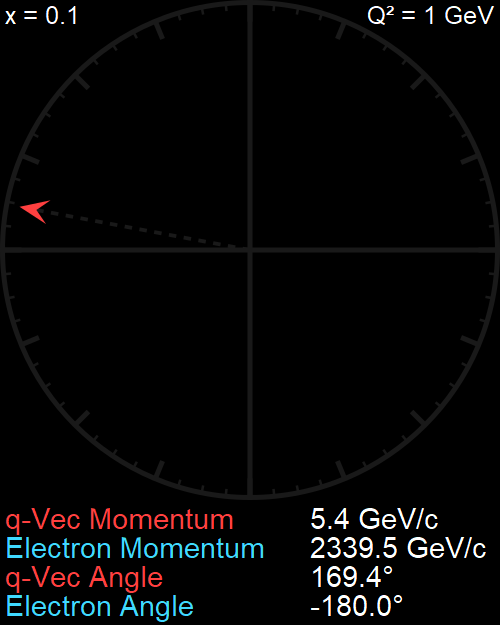

In [20]:
# initialize surface
surface = cairo.ImageSurface(cairo.Format.ARGB32, w, int(h*1.25))
ctx = cairo.Context(surface)

ctx.scale(w, h)

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'Proton Momentum', f'{pr_proton_momentum:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{pr_electron_momentum:.1f} GeV/c'],
         [red, 'Proton Angle', f'{math.degrees(pr_proton_angle):.1f}°'],
         [blue, 'Electron Angle', f'{math.degrees(pr_electron_angle):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

# these are the different times for the two animations
t1 = abs( 0.5/pr_electron_speed )
t2 = abs( 0.5/cos(cm_proton_angle_after)/cm_proton_speed_after )
T = t1 + t2

ctx.save()
ctx.translate(0.5, 0.5)

for frame, t in enumerate( np.linspace(0, t1, ceil(5*60*t1/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)
    
    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')
            
    # animation

    # Draw the proton vector
    ctx.save()
    ctx.rotate( pr_proton_angle )
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    ctx.stroke()
    ctx.arc(0, 0, 0.02, 0, 2*pi)
    ctx.fill()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( pr_electron_angle )
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*pr_electron_speed-0.75, 0, 0)
    ctx.stroke()
    ctx.restore()

    # save as .png
    surface.write_to_png(f'proton_rest/{frame:03d}.png')

ctx.restore()

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'q-Vec Momentum', f'{pr_proton_momentum_after:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{pr_electron_momentum_after:.1f} GeV/c'],
         [red, 'q-Vec Angle', f'{-math.degrees(pr_proton_angle_after):.1f}°'],
         [blue, 'Electron Angle', f'{-math.degrees(pr_electron_angle_after):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

ctx.save()
ctx.translate(0.5, 0.5)
    
for frame, t in enumerate( np.linspace(0, t2, ceil(5*60*t2/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)

    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')
            
    # animation
    
    # Draw the proton vector
    ctx.save()
    ctx.rotate( pr_electron_angle_after )
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*pr_electron_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.save()
    ctx.rotate( pr_proton_angle_after )
    
    ctx.save()
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*pr_proton_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25*pr_proton_momentum_after/pr_electron_momentum_after, t*pr_proton_speed_after, 0, 0)
    ctx.stroke()
    # ctx.arc(0, 0, 0.02, 0, 2*pi)
    # ctx.fill()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( pr_electron_angle_after )
    
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*pr_electron_speed_after, 0, 0)
    ctx.stroke()
    ctx.restore()

    # save as .png
    surface.write_to_png(f'proton_rest/{ frame + ceil(5*60*t1/T) :03d}.png')
    
# display in notebook
with BytesIO() as fileobj:
    surface.write_to_png(fileobj)
    display(Image(fileobj.getvalue(), width=w))

## Collider Frame

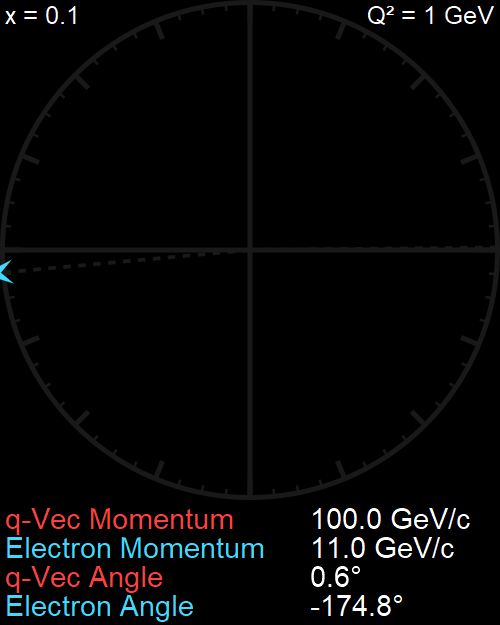

In [11]:
# initialize surface
surface = cairo.ImageSurface(cairo.Format.ARGB32, w, int(h*1.25))
ctx = cairo.Context(surface)

ctx.scale(w, h)

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'Proton Momentum', f'{co_proton_momentum:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{co_electron_momentum:.1f} GeV/c'],
         [red, 'Proton Angle', f'{-math.degrees(co_proton_angle):.1f}°'],
         [blue, 'Electron Angle', f'{-math.degrees(co_electron_angle):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

# these are the different times for the two animations
t1 = 0.5/co_proton_speed
t2 = 0.5/cos(co_proton_angle_after)/co_proton_speed_after
T = t1 + t2

ctx.save()
ctx.translate(0.5, 0.5)

for frame, t in enumerate( np.linspace(0, t1, ceil(5*60*t1/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)

    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')
            
    # animation

    # Draw the proton vector
    ctx.save()
    ctx.rotate( co_proton_angle )
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*co_proton_speed -0.75, 0, 0)
    ctx.stroke()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( co_electron_angle )
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    ah = ctx.get_line_width()*3.42709
    draw_arrow(ctx, 0.25*co_electron_momentum/co_proton_momentum, t*co_electron_speed-0.5-ah, 0, 0)
    ctx.stroke()
    ctx.restore()

    # save as .png
    surface.write_to_png(f'collider/{frame:03d}.png')

ctx.restore()

# text
ctx.set_source_rgba(0, 0, 0, 1)
ctx.rectangle(0, 1, 1, 0.25)
ctx.fill()
                             
ctx.save()
ctx.translate(0, 1)

lines = [[red, 'q-Vec Momentum', f'{co_proton_momentum_after:.1f} GeV/c'],
         [blue, 'Electron Momentum', f'{co_electron_momentum_after:.1f} GeV/c'],
         [red, 'q-Vec Angle', f'{-math.degrees(co_proton_angle_after):.1f}°'],
         [blue, 'Electron Angle', f'{-math.degrees(co_electron_angle_after):.1f}°']
        ]
                             
left_margin = 0.01
tab = 0.62
font_size = 0.25/4.3

ctx.set_font_size(font_size)
for number, line in enumerate(lines, start=1):
    color, line1, line2 = line
    
    ctx.set_source_rgba(*color)
    ctx.move_to(left_margin, font_size*number)
    ctx.show_text(line1)
    
    ctx.set_source_rgba(1, 1, 1, 1)
#     (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(line2) 
    ctx.move_to(tab, font_size*number)
    ctx.show_text(line2)
    ctx.stroke()

ctx.restore()

ctx.save()
ctx.translate(0.5, 0.5)
    
for frame, t in enumerate( np.linspace(0, t2, ceil(5*60*t2/T) ) ):
    # Background 
    ctx.set_source_rgba(0, 0, 0, 1)
    ctx.move_to(0, 0)
    ctx.rectangle(-0.5, -0.5, 1, 1)
    ctx.fill()

    # Axes
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.move_to(-0.5, 0)
    ctx.line_to(0.5, 0)
    ctx.stroke()

    ctx.move_to(0, -0.5)
    ctx.line_to(0, 0.5)
    ctx.stroke()

    # Unit circle with notches
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.01)

    ctx.arc(0, 0, unit_circle_radius, 0, 2*pi)
    ctx.stroke()

    for minute in range(16):
        ctx.move_to(unit_circle_radius, 0)
        ctx.line_to(unit_circle_radius*12/13, 0)
        ctx.stroke()

        for second in range(4):
            ctx.set_line_width(0.005)
            ctx.move_to(unit_circle_radius, 0)
            ctx.line_to(unit_circle_radius*0.97, 0)
            ctx.rotate(2*pi/16/4)
            ctx.stroke()
            ctx.set_line_width(0.01)
            
    # more text!
    ctx.set_font_size(0.05)
    ctx.set_source_rgba(1, 1, 1, 1)
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'Q² = {Q2:.0f} GeV') 
    ctx.move_to(0.5-tw-0.01, -0.5+th+0.01)
    ctx.show_text(f'Q² = {Q2:.0f} GeV')
    (tx, ty, tw, th, tdx, tdy) = ctx.text_extents(f'x = {xB:.1f}') 
    ctx.move_to(-0.5+0.01, -0.5+th+0.01)
    ctx.show_text(f'x = {xB:.1f}')

    # animation
    
    # Draw the proton vector
    ctx.save()
    ctx.rotate( co_proton_angle_after )
    
    ctx.save()
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*co_proton_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.set_source_rgba(*red)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25, t*co_proton_speed_after, 0, 0)
    ctx.stroke()
    ctx.restore()

    # Draw the electron vector
    ctx.save()
    ctx.rotate( co_electron_angle_after )
    
    ctx.save()
    ctx.set_source_rgba(*almost_black)
    ctx.set_line_width(0.0075)
    ctx.set_dash([0.0075*2])
    ctx.move_to(0, 0)
    ctx.line_to(t2*co_electron_speed_after, 0)
    ctx.stroke()
    ctx.restore()
    
    ctx.set_source_rgba(*blue)
    ctx.set_line_width(0.01)
    draw_arrow(ctx, 0.25*co_electron_momentum_after/co_proton_momentum_after, t*co_electron_speed_after, 0, 0)
    ctx.stroke()
    ctx.restore()
    
    # save as .png
    surface.write_to_png(f'collider/{ frame + ceil(5*60*t1/T) :03d}.png')
    
# display in notebook
with BytesIO() as fileobj:
    surface.write_to_png(fileobj)
    display(Image(fileobj.getvalue(), width=w))